<a href="https://colab.research.google.com/github/mancunian1792/LatentSpaceClustering_GenerativeModels/blob/main/cluster_gan_resnet_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.0
!pip install torchvision==0.2.1
!pip install pillow==6.0.0

In [ ]:
import torch
from torch import nn
import  torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10 # Training dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from itertools import chain
from torch.autograd import Variable
from tqdm.notebook import tqdm as tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from time import time
from sklearn import metrics
from torchvision.models import resnet50
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(torch.__version__)

1.0.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Weight Initializer
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Reshape(nn.Module):
    """
    Class for performing a reshape as a layer in a sequential model.
    """
    def __init__(self, shape=[]):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)
    
    def extra_repr(self):
            # (Optional)Set the extra information about this module. You can test
            # it by printing an object of this class.
            return 'shape={}'.format(
                self.shape
            )
# Encoder Network Class

class Encoder_Resnet(nn.Module):
  '''
  Encoder model
  '''
  def __init__(self, image_shape, latent_dim, num_classes):
    super(Encoder_Resnet, self).__init__()
    self.num_channels = image_shape[0]
    self.latent_dim = latent_dim
    self.num_classes = num_classes
    self.img_shape = (image_shape[1], image_shape[2])
    self.conv_shape = (2048, 1, 1) # Shape after convolution - Can we figure it out automatically ?
    self.iels = int(np.prod(self.conv_shape))
    self.lshape = (self.iels,)

    # Convolutional Block - Resnet
    res_net = resnet50(pretrained=True)
    modules = list(res_net.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    for child in self.resnet.children():
      for param in child.parameters():
        param.requires_grad = False 
     
    # Flatten Block
    self.reshape = Reshape(self.lshape)

    # Fully Connected Layers
    self.fc = nn.Sequential(
        nn.Linear(self.iels, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.latent_dim + self.num_classes)
    )
    #initialize_weights(self)

  def forward(self, img):
    conv_img = self.resnet(img)
    reshape_img = self.reshape(conv_img)
    z_img = self.fc(reshape_img) # (batch_size , 40)
    
    z = z_img.view(z_img.shape[0], -1)
    # Separate continuous and one-hot components
    zn = z[:, 0:self.latent_dim] # bs, 30
    zc_logits = z[:, self.latent_dim:] # bs, 10
    # Softmax on zc component
    zc = F.softmax(zc_logits, dim=1)
    return zn, zc, zc_logits


# Generator Network Class
class Generator_Resnet(nn.Module):
  def __init__(self, latent_dim, num_classes, image_shape):
    super(Generator_Resnet, self).__init__()

    self.latent_dim = latent_dim
    self.num_classes = num_classes
    self.image_shape = image_shape

    self.ishape = (2048, 1, 1)
    self.dshape = (1024,1,1)
    self.iels = int(np.prod(self.ishape))
    self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
    self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
    self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

    #Full connected layers
    self.fc = nn.Sequential(
        nn.Linear(self.latent_dim + self.num_classes, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2),
    )

    #reshape
    self.reshape = Reshape(self.ishape)
    self.img_reshape = Reshape(self.dshape)
    #Upconvolution Layers
    self.convTrans1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
    self.convTrans2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

    self.convTrans3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )

    initialize_weights(self)
  def forward(self, zn, zc):
    z = torch.cat((zn, zc), 1)
    fc_img = self.fc(z)
    reshape_img = self.img_reshape(fc_img)

    x1 = self.convTrans1(reshape_img.view(-1, 64,4,4))
    x2 = self.convTrans2(x1)
    x3 = self.convTrans3(x2)
    # Reshape for output
    x_gen = F.interpolate(x3, size=(224, 224), mode='bilinear')
    return x_gen

# Discriminator Network Class
class Discriminator_Resnet(nn.Module):
  def __init__(self, image_shape):

    super(Discriminator_Resnet, self).__init__()

    self.channels = image_shape[0]
    self.conv_shape = (2048, 1, 1)
    self.iels = int(np.prod(self.conv_shape))
    self.lshape = (self.iels,) 

   # Convolutional Block - Resnet
    res_net = resnet50(pretrained=True)
    modules = list(res_net.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    for child in self.resnet.children():
      for param in child.parameters():
        param.requires_grad = False 

    # Flatten
    self.flatten = Reshape(self.lshape)

    # Fully connected layers
    self.fc = nn.Sequential(
        nn.Linear(self.iels, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 1),
        nn.Sigmoid()
    )
    #initialize_weights(self)
  def forward(self, img):
    conv_img = self.resnet(img)
    flatten_img = self.flatten(conv_img)
    validity = self.fc(flatten_img)

    return validity

In [ ]:
n_epochs = 100
test_batch_size = 5000
lr = 1e-4 #learning rate for both optimizers.
b1 = 0.5 # default - associated with optimizer to calculate gradient.
b2 = 0.9 #0.99 default - associated with optimizer to calculate gradient.
decay = 2.5*1e-5 # decay rate optimizer. 
n_skip_iter = 1 #5 When does my encoder and generator train
latent_dim = 30
num_classes = 10
batch_size = 16
betan = 10 # Beta associated with clustering  loss (From the loss function mentioned in paper)
betac = 10 # Beta associated with the cross entropy (From the loss function mentioned in paper)


In [ ]:
dataset_type = "cifar"
img_size = 224 if dataset_type == "cifar" else 28
channels = 3 if dataset_type == "cifar" else 1
image_shape = (channels, img_size, img_size)

DATA = MNIST if dataset_type == "mnist" else FashionMNIST if dataset_type == "fashion" else CIFAR10

transform_data = transforms.Compose([transforms.Resize(size=(224, 224)), transforms.ToTensor()])  if dataset_type in "cifar" else transforms.ToTensor()

dataloader = DataLoader(
    DATA('.', download=True, transform=transform_data),
    batch_size=batch_size,
    shuffle=True)

train_dataset = DATA('./'+ dataset_type+'/', download= True, transform= transform_data, train=True)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)


test_dataset = DATA('./'+ dataset_type+'/', download= True, transform= transform_data, train=False)
test_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def sample_zs(batch_size, latent_dim, num_classes, cuda = True, fix_class = -1, req_grad = False):
  '''
  create a zn from random normal -> (bs, latent_dim)
  '''
  assert (fix_class == -1 or (fix_class >= 0 and fix_class < num_classes) ), "Requested class %i outside bounds."%fix_class
  shape = batch_size
  Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
  
  # Sample noise as generator input, zn
  zn = Variable(Tensor(0.75*np.random.normal(0, 1, (shape, latent_dim))), requires_grad=req_grad)

  ######### zc, zc_idx variables with grads, and zc to one-hot vector
  # Pure one-hot vector generation
  zc_FT = Tensor(shape, num_classes).fill_(0) # Filling it with 0
  zc_idx = torch.empty(shape, dtype=torch.long) # empty torch tensor with shape (bs,)
  zc_idx = zc_idx.cuda() if cuda else zc_idx
  zc_FT = zc_FT.cuda() if cuda else zc_FT
  
  if (fix_class == -1): # During training
      zc_idx = zc_idx.random_(num_classes)# Random classes between  with shape (bs, )
      zc_FT = zc_FT.scatter_(1, zc_idx.unsqueeze(1), 1.)
  else: # Conditional generation
      zc_idx[:] = fix_class
      zc_FT[:, fix_class] = 1

  
  zc = Variable(zc_FT, requires_grad=req_grad)
  return zn, zc, zc_idx

In [ ]:
def train(dataset_type):

  encoder = Encoder_Resnet(image_shape=image_shape, 
                    latent_dim=latent_dim, 
                    num_classes=num_classes)

  generator = Generator_Resnet(image_shape=image_shape, 
                        latent_dim=latent_dim,
                        num_classes=num_classes)

  discriminator = Discriminator_Resnet(image_shape=image_shape)

  # Loss function
  bce_loss = nn.BCELoss() # Discriminator loss
  xe_loss = nn.CrossEntropyLoss() # cross _entropy loss to associate the z vectors to correct label.
  mse_loss = nn.MSELoss() # Clustering loss to associate the z vectors of same label close together.

  cuda = True if torch.cuda.is_available() else False
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  gen_enc_losses = []
  disc_losses = []
  if cuda:
    generator.to(device)
    encoder.to(device)
    discriminator.to(device)
    bce_loss.to(device)
    xe_loss.to(device)
    mse_loss.to(device)

  ge_chain = chain(generator.parameters(),
                        encoder.parameters())

  optimizer_GE = torch.optim.Adam(ge_chain, lr=lr, betas=(b1, b2), weight_decay=decay)
  optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
  Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

  for epoch in tqdm(range(n_epochs)):
    for batch_num, (real_imgs, real_labels) in enumerate(train_loader):
      real_imgs = Variable(real_imgs.type(Tensor))
      # We put generator and encoder in training mode.
      # Generator need -> Some noise to start with (batch_size, latent_dim + num_classes) -> Fake image.
      # Encoder needs the fake image generated by generator get the z that would have created the fake image.
      generator.train()
      encoder.train()
      generator.zero_grad()
      encoder.zero_grad()
      discriminator.zero_grad()
      optimizer_GE.zero_grad()
      zn, zc, zc_idx = sample_zs(real_imgs.shape[0], latent_dim, num_classes, cuda=cuda)
      # Generator uses the zn and zc to produce fake image
      fake_image = generator(zn, zc)
      fake_img_enc = fake_image.clone()
      fake_img_disc = fake_image.clone()

      
      fake_output = discriminator(fake_img_disc)
      real_output = discriminator(real_imgs)
      encoder_zn, encoder_zc, encoder_logits = encoder(fake_img_enc)

      # Get the losses.
      # mse loss, xe loss and bce_loss
      zn_loss = mse_loss(encoder_zn, zn)
      zc_loss = xe_loss(encoder_logits, zc_idx)
      real_tensor = Variable(Tensor(fake_image.size(0), 1).fill_(1.0), requires_grad=False)
      bc_loss = bce_loss(fake_output, real_tensor)
      ge_loss = bc_loss + (betan * zn_loss) + (betac * zc_loss)
      # Backpropogate generator and encoder.
      ge_loss.backward(retain_graph=True)
      optimizer_GE.step()
    
      # Backpropogate for discriminator
      # This should clear out the prev grad attribute.
      optimizer_D.zero_grad()
      fake_tensor = Variable(Tensor(fake_image.size(0), 1).fill_(0.0), requires_grad=False)
      fake_loss =  bce_loss(fake_output, fake_tensor)
      real_loss = bce_loss(real_output, real_tensor)
      discriminator_loss = (fake_loss + real_loss)/2
      discriminator_loss.backward()
      optimizer_D.step()
      
      
    
    gen_enc_losses.append(ge_loss.item())
    disc_losses.append(discriminator_loss.item())
    
    print(f" Epoch number {epoch} -- Generator-Encoder loss is {ge_loss.item()} -- Discriminator Loss is {discriminator_loss.item()}")

    if epoch % 50 == 0:
      # save generator, encoder and discriminator model weights every 10 epoch
      torch.save(generator.state_dict(), '/content/gdrive/MyDrive/latent_space_clustering/cluster_gan_simple/harish_runs/'+dataset_type+'generator_model.pth')
      torch.save(encoder.state_dict(), '/content/gdrive/MyDrive/latent_space_clustering/cluster_gan_simple/harish_runs/'+dataset_type+'encoder_model.pth')
      torch.save(discriminator.state_dict(), '/content/gdrive/MyDrive/latent_space_clustering/cluster_gan_simple/harish_runs/'+dataset_type+'discriminator_model.pth')
      

In [ ]:
train("cifar_resnet")

 Epoch number 0 -- Generator-Encoder loss is 6.920252799987793 -- Discriminator Loss is 0.08676930516958237
 Epoch number 1 -- Generator-Encoder loss is 7.903904438018799 -- Discriminator Loss is 0.03773658350110054
 Epoch number 2 -- Generator-Encoder loss is 7.4314069747924805 -- Discriminator Loss is 0.08587153255939484
 Epoch number 3 -- Generator-Encoder loss is 10.334529876708984 -- Discriminator Loss is 0.05006454139947891
 Epoch number 4 -- Generator-Encoder loss is 6.427321910858154 -- Discriminator Loss is 0.07868363708257675
 Epoch number 5 -- Generator-Encoder loss is 8.102476119995117 -- Discriminator Loss is 0.015414915047585964
 Epoch number 6 -- Generator-Encoder loss is 9.86669921875 -- Discriminator Loss is 0.15642625093460083
 Epoch number 7 -- Generator-Encoder loss is 8.507136344909668 -- Discriminator Loss is 0.13230258226394653
 Epoch number 8 -- Generator-Encoder loss is 8.117715835571289 -- Discriminator Loss is 0.10622867941856384
 Epoch number 9 -- Generator-

In [ ]:
imgs_ = []
labels_ = []
for i in range(100):
    imgs, labels = next(iter(train_loader))
    imgs_.append(imgs)
    labels_.append(labels)
imgs = torch.cat(imgs_, dim = 0)
labels = torch.cat(labels_, dim = 0)

In [ ]:
encoder = Encoder_Resnet(image_shape=image_shape, 
                    latent_dim=latent_dim, 
                    num_classes=num_classes)

generator = Generator_Resnet(image_shape=image_shape, 
                        latent_dim=latent_dim,
                        num_classes=num_classes)

discriminator = Discriminator_Resnet(image_shape=image_shape)

### Testing Reconstruction

In [ ]:
encoder.load_state_dict(torch.load('/content/gdrive/MyDrive/latent_space_clustering/cluster_gan_simple/harish_runs/cifar_resnetencoder_model.pth'))
generator.load_state_dict(torch.load('/content/gdrive/MyDrive/latent_space_clustering/cluster_gan_simple/harish_runs/cifar_resnetgenerator_model.pth'))
encoder.eval()
generator.eval()

Generator_Resnet(
  (fc): Sequential(
    (0): Linear(in_features=40, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (reshape): Reshape(shape=(2048, 1, 1))
  (img_reshape): Reshape(shape=(1024, 1, 1))
  (convTrans1): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (convTrans2): Sequential(
    (0): ConvTranspose2d(32, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (convTrans3): Sequential(
    (0): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.cm as cm
tsne = TSNE(n_components=2, verbose=1, init='pca', random_state=42)
enc_zn, enc_zc, enc_zc_logits = encoder(imgs)
enc = np.hstack((enc_zn.cpu().detach().numpy(), enc_zc_logits.cpu().detach().numpy()))
tsne_enc = tsne.fit_transform(enc)
labels = labels.data.numpy()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.021s...
[t-SNE] Computed neighbors for 1600 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 26.061210
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.588333
[t-SNE] KL divergence after 1000 iterations: 0.725815


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

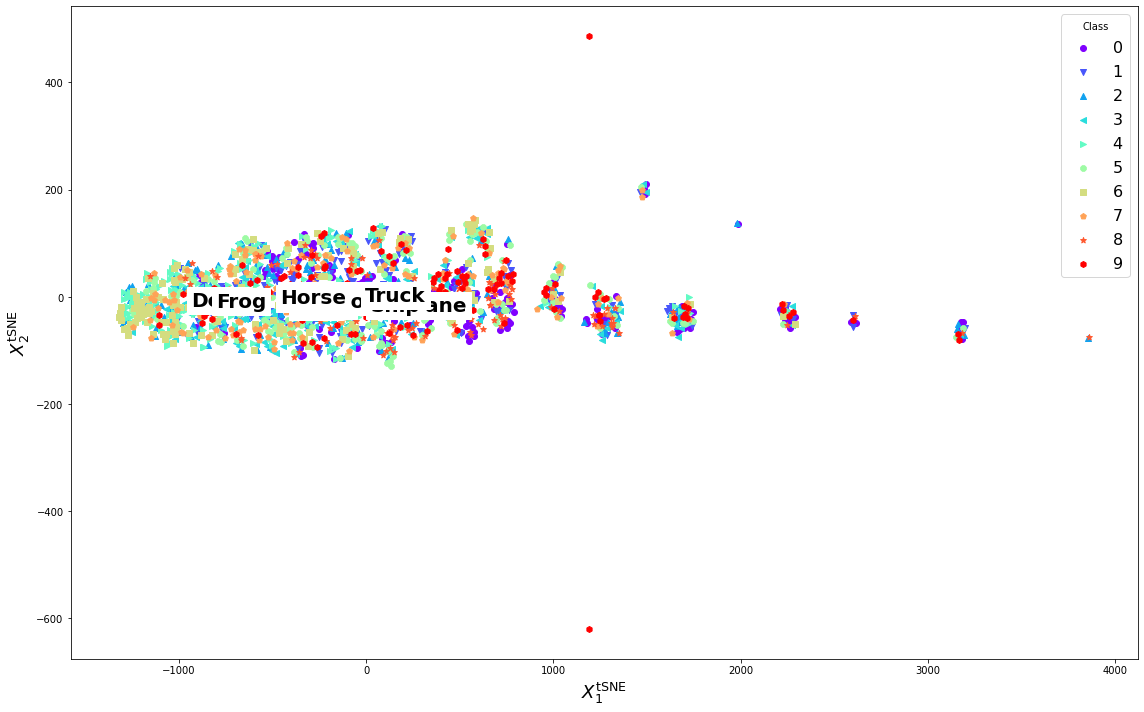

In [ ]:
nr_c = 10
colors = cm.rainbow(np.linspace(0, 1, nr_c))
markers = matplotlib.markers.MarkerStyle.filled_markers
class_labels = ["T-shirt/top", "Trouser" ,"Pullover", "Dress" ,"Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"] if dataset_type == "fashion" else ["0","1", "2", "3","4","5","6","7","8","9"] if dataset_type == "mnist" else ["Airplane", "Automobile" ,"Bird", "Cat" ,"Deer","Dog", "Frog", "Horse", "Ship", "Truck"]
    # Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16,10))
for iclass in range(0, nr_c):
        # Get indices for each class
    idxs = labels==iclass
        # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0],
                tsne_enc[idxs, 1],
                marker=markers[iclass],
                c=colors[iclass],
                edgecolor=None,
                label=r'$%i$'%iclass)

    ax.set_xlabel(r'$X^{\mathrm{tSNE}}_1$', fontsize=18)
    ax.set_ylabel(r'$X^{\mathrm{tSNE}}_2$', fontsize=18)
    plt.legend(title=r'Class', loc='best', numpoints=1, fontsize=16)
    plt.annotate(class_labels[iclass], 
                 np.median([tsne_enc[idxs ,0], tsne_enc[idxs ,1]], axis=1),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='black',
                 backgroundcolor='white') 
    plt.tight_layout()
    fig.savefig('tsne-pca.png')

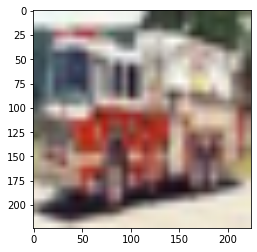

In [ ]:
sample_img = imgs[111].unsqueeze(0)
zn, zc, zc_idx = encoder(sample_img)
reconstructed_img = generator(zn, zc)

plt.imshow(sample_img.squeeze(0).permute((1,2,0)).detach().cpu())


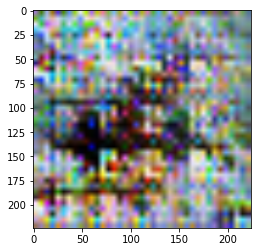

In [ ]:
plt.imshow(reconstructed_img.squeeze(0).permute((1,2,0)).detach().cpu())


In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
  table = PrettyTable(["Modules", "Parameters"])
  total_params = 0
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad: 
      continue
    param = parameter.numel()
    table.add_row([name, param])
    total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
  return total_params

count_parameters(encoder) 

+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| fc.0.weight |  2097152   |
+-------------+------------+
Total Trainable Params: 2097152
+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| fc.0.weight |  2097152   |
|  fc.0.bias  |    1024    |
+-------------+------------+
Total Trainable Params: 2098176
+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| fc.0.weight |  2097152   |
|  fc.0.bias  |    1024    |
| fc.2.weight |   40960    |
+-------------+------------+
Total Trainable Params: 2139136
+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| fc.0.weight |  2097152   |
|  fc.0.bias  |    1024    |
| fc.2.weight |   40960    |
|  fc.2.bias  |     40     |
+-------------+------------+
Total Trainable Params: 2139176


2139176